In [1]:
import os, sys
sys.path.append('/workspaces/python-trend-labeller')

In [2]:
from collections import Counter
from typing import List
import matplotlib.pyplot as plt
import pandas as pd

from src.trend_labelling.ternary_CTL import TernaryCTL
from src.viz import plot_trend_labels


In [3]:
df_list = []
for file in os.listdir('/workspaces/python-trend-labeller/notebooks/data'):
    if file.endswith('.parquet'):
        df_list.append(pd.read_parquet(f'/workspaces/python-trend-labeller/notebooks/data/{file}'))
df = pd.concat(df_list)

df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 17438 entries, 0 to 2759
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v       17438 non-null  int64  
 1   vw      17438 non-null  float64
 2   o       17438 non-null  float64
 3   c       17438 non-null  float64
 4   h       17438 non-null  float64
 5   l       17438 non-null  float64
 6   t       17438 non-null  int64  
 7   n       17438 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 1.2 MB


In [4]:
def plot_trend_labels(time_series_list: list[str], labels: list[int]) -> None:
    """
    Visualize the price series with trend labels.

    Args:
        time_series_list (list[str]): The price series.
        labels (list[int]): Optimal trend labels (0 for downtrend, 1 for uptrend).
    """

    plt.figure(figsize=(10, 6))
    plt.plot(time_series_list, label="Price", color="blue", linewidth=2)

    # Highlight trends
    for t in range(len(time_series_list) - 1):
        if labels[t] == 1:  # Uptrend
            plt.axvspan(
                t,
                t + 1,
                color="green",
                alpha=0.3,
            )
        elif labels[t] == 0:  # No trend
            plt.axvspan(
                t,
                t + 1,
                color="gray",
                alpha=0.3,
                )
        elif labels[t] == -1:  # Downtrend
            plt.axvspan(
                t,
                t + 1,
                color="red",
                alpha=0.3,
            )

    plt.xlabel("Time")
    plt.title("Trend Labeling Visualization")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [5]:
import numpy as np


class LabelReturnCalculator:
    def __init__(
        self,
        prices: list[float],
        labels: list[int],
        holding_long_position_cost_fraction: float = 0,
        holding_short_position_cost_fraction: float = 0,
        long_position_fixed_fee: float = 0,
        short_position_fixed_fee: float = 0,
        long_position_percentage_fee: float = 0,
        short_position_percentage_fee: float = 0,
    ) -> None:
        self.verify_input_data(prices, labels)
        self.prices = prices
        self.labels = labels
        self.holding_long_position_cost_fraction = holding_long_position_cost_fraction 
        self.holding_short_position_cost_fraction = holding_short_position_cost_fraction
        self.long_position_fixed_fee = long_position_fixed_fee
        self.short_position_fixed_fee = short_position_fixed_fee
        self.long_position_percentage_fee = long_position_percentage_fee
        self.short_position_percentage_fee = short_position_percentage_fee

    def verify_input_data(self, prices: list[float], labels: list[int]) -> None:
        if len(prices) != len(labels):
            raise ValueError("The length of prices and labels must be the same")
        if not all(isinstance(price, (int, float)) for price in prices):
            raise ValueError("Prices must be a list of numbers")
        if not all(label in {-1, 0, 1} for label in labels):
            raise ValueError("Labels must be a list of -1, 0, 1")

    def _calculate_return_from_labels(self) -> float:
        return_value = [
            (self.prices[i + 1] - self.prices[i]) * self.labels[i + 1]
            for i in range(len(self.prices) - 1)
        ]
        return sum(return_value)
    
    def _estimate_fixed_transaction_fees(self) -> float:
        total_fees = 0
        for label_value, fee in zip([1, -1], [self.long_position_fixed_fee, self.short_position_fixed_fee]):        
            nb_positions = sum(1 for i in range(1, len(self.labels)) if self.labels[i] == label_value and self.labels[i-1] != label_value) + int(self.labels[0] == label_value)
            total_fees += nb_positions*fee
        return total_fees

    def _estimate_percentage_transaction_fees(self) -> float:
        total_fees = 0
        for label_value, fee in zip([1, -1], [self.long_position_percentage_fee, self.short_position_percentage_fee]):
            total_fees += sum(self.prices[i-1] for i in range(1, len(self.labels)) if self.labels[i] != label_value and self.labels[i-1] == label_value) * fee
        return total_fees
    
    def _estimate_holding_fees(self) -> float:
        labels_counter = Counter(self.labels)
        return labels_counter[1]*self.holding_long_position_cost_fraction + labels_counter[-1]*self.holding_short_position_cost_fraction
    
    def _estimate_fees(self) -> float:
        return self._estimate_fixed_transaction_fees() + self._estimate_percentage_transaction_fees() + self._estimate_holding_fees()
    
    def estimate_return(self) -> float:
        return self._calculate_return_from_labels() - self._estimate_fees()
    
    

Counter({-1: 11115, 1: 6029, 0: 294})


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x790f3c84e3c0>>
Traceback (most recent call last):
  File "/home/asder/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


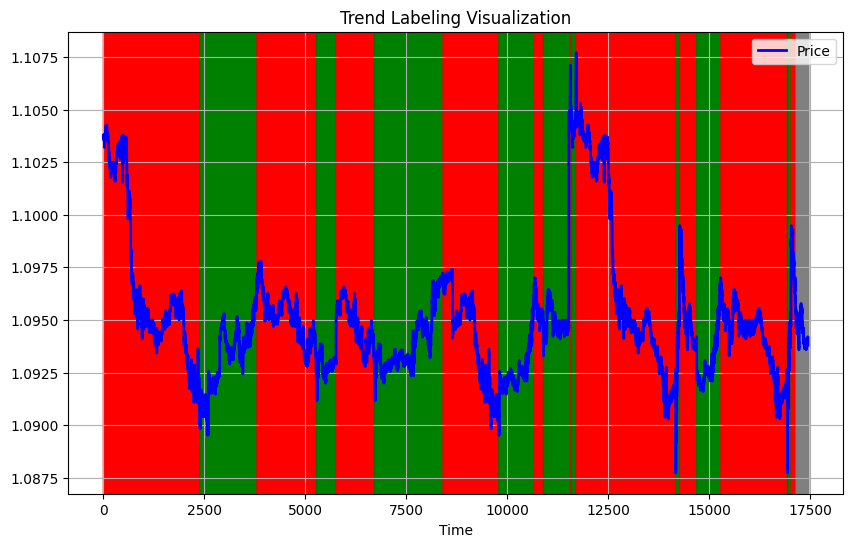

In [6]:
from collections import Counter


labeller = TernaryCTL(marginal_change_thres=0.002, window_size=2000)
labels = labeller.get_labels(df.c.to_list())
print(Counter(labels))

# 
plot_trend_labels(df.c.to_list(), labeller.labels)

# Optimise with bayes

In [25]:
def calculate_return_with_params(marginal_change_thres: float, window_size: int) -> float:
    window_size_int = int(window_size)
    labeller = TernaryCTL(marginal_change_thres=marginal_change_thres, window_size=window_size_int)
    total_return = 0
    for daily_df in df_list:
        labels = labeller.get_labels(daily_df.c.to_list())
        returns_estimator = LabelReturnCalculator(daily_df.c.to_list(), labels, holding_long_position_cost_fraction=0.000001, holding_short_position_cost_fraction=0.000001, long_position_percentage_fee=0.0008, short_position_percentage_fee=0.0008)
        total_return += returns_estimator.estimate_return()
    return total_return


In [32]:
from bayes_opt import BayesianOptimization
from bayes_opt import acquisition
optimiser = BayesianOptimization(f=calculate_return_with_params, pbounds={"marginal_change_thres": (0.000001, 0.02), "window_size": (10, 3000)}, verbose=2,
                                 acquisition_function=acquisition.UpperConfidenceBound(kappa=0.1))
optimiser.maximize(n_iter=100)
    

|   iter    |  target   | margin... | window... |
-------------------------------------------------
| 1         | 0.0       | 0.01853   | 2.191e+03 |
| 2         | 0.0       | 0.01546   | 1.177e+03 |
| 3         | 0.01416   | 0.00937   | 2.12e+03  |
| 4         | 0.01349   | 0.005227  | 1.17e+03  |
| 5         | 0.01897   | 0.00603   | 1.644e+03 |
| 6         | 0.0       | 0.01603   | 1.306e+03 |
| 7         | 0.03601   | 0.003658  | 2.137e+03 |
| 8         | 0.0       | 0.01688   | 1.759e+03 |
| 9         | 0.0       | 0.01703   | 2.618e+03 |
| 10        | 0.0       | 0.01829   | 948.3     |
| 11        | 0.01102   | 0.006814  | 1.673e+03 |
| 12        | 0.032     | 0.002747  | 392.8     |
| 13        | -0.2364   | 0.0003972 | 1.204e+03 |
| 14        | 0.0       | 0.01923   | 2.135e+03 |
| 15        | 0.0       | 0.01926   | 2.139e+03 |
| 16        | 0.0       | 0.01787   | 2.137e+03 |
| 17        | 0.0       | 0.01931   | 2.137e+03 |
| 18        | 0.003454  | 0.004184  | 46.29     |


Counter({-1: 10106, 1: 7038, 0: 294})


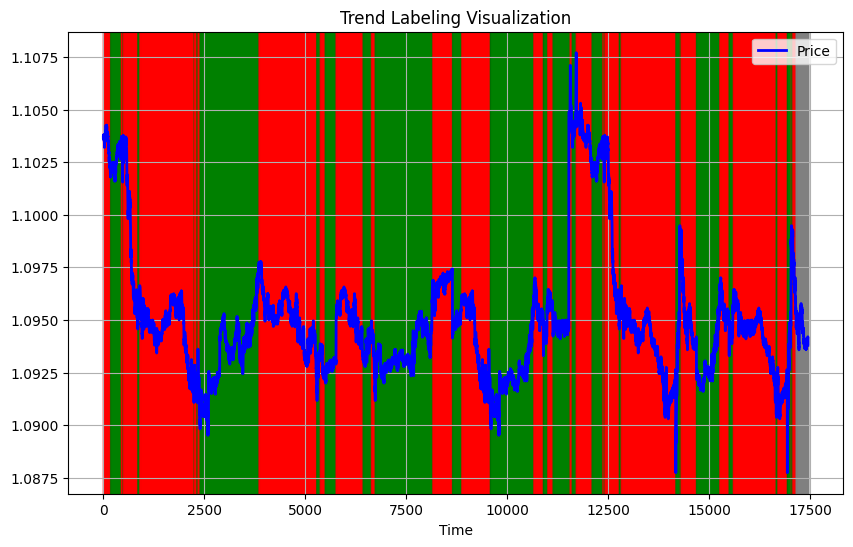

In [27]:

labeller = TernaryCTL(marginal_change_thres=0.0016, window_size=1350)
labels = labeller.get_labels(df.c.to_list())
print(Counter(labels))

# 
plot_trend_labels(df.c.to_list(), labeller.labels)